In [3]:
import pandas as pd
from datetime import datetime

########### Start of dataPreparation Function #########################
def dataPreparation(dataFrame):
    
    ######### "Airline Column" #############
    dummies = pd.get_dummies(dataFrame.Airline)
    dataFrame[dummies.columns] = dummies
    dataFrame = dataFrame.drop("Airline", axis = 1)
    ########################################
    
    ######## "Source and Destination Column" ########
    dummies = pd.get_dummies(dataFrame.Source)
    columns = []
    for colName in dummies.columns:
         columns.append(colName + "_Source")
    dataFrame[columns] = dummies
    dummies = pd.get_dummies(dataFrame.Destination)
    columns = []
    for colName in dummies.columns:
         columns.append(colName + "_Destination")
    dataFrame[columns] = dummies
    dataFrame = dataFrame.drop(["Source", "Destination"], axis = 1)
    #################################################
    
    ########## "Date_of_Journey Column"##############
    def compare_dates(date):

        date_format = '%d/%m/%Y'
        current_date = datetime.strptime(date, date_format)  
        today = datetime.strptime('01/01/2019', date_format)
        diff = current_date - today
        
        return diff.days

    dataFrame['days_since'] = dataFrame['Date_of_Journey'].apply(compare_dates)
    #################################################
    
    ############### "Route Column" ##################
    dataFrame = dataFrame.drop("Route", axis = 1)
    #################################################
    
    ############## "Duration Column"#################
    def convert_to_minutes(value):
        time = value.split(' ')
        if len(time) == 2:
            return int(time[0][:-1]) * 60 + int(time[1][:-1])
        elif len(time) == 1:
            if time[0][-1] == 'h':
                return int(time[0][:-1]) * 60
            elif time[0][-1] =='m':
                return int(time[0][:-1])
        else:
            return 0
    dataFrame['Duration'] = dataFrame['Duration'].apply(convert_to_minutes)
    #################################################
    
    ############# "Total_Stops" ######################
    def stops_convert_to_numeric(value):
        if str(value)[0] == 'n':
            return 0
        else:
            return int(str(value)[0])
    dataFrame['Total_Stops'] = dataFrame['Total_Stops'].apply(stops_convert_to_numeric)
    ##################################################
    
    ############# "Additional_Info Column" ###############
    def info_convert_to_numeric(value):
        class1 = set(['No info', 'In-flight meal not included', 'No check-in baggage included', 'No Info'])
        class2 = set(['1 Short layover', '1 Long layover', '2 Long layover', 'Change airports', 'Red-eye flight'])
        class3 = set(['Business class'])
        if str(value) in class1:
            return 0
        elif str(value) in class2:
            return 5
        elif str(value) in class3:
            return 20

    dataFrame['Additional_Info'] = dataFrame['Additional_Info'].apply(info_convert_to_numeric)
    ######################################################
    
    ############### "Dep_Time and Arrival_Time Column" #########
    def time_to_numeric(value):
        time = str(value).split(':')
        if int(time[0])  < 7 and int(time[0]) > 19 :
            return 1
        elif int(time[0]) > 15 and int(time[0]) < 19:
            return 4
        elif int(time[0]) > 7 and int(time[0]) < 10:
            return 4
        else:
            return 1

    dataFrame['Dep_Time'] = dataFrame['Dep_Time'].apply(time_to_numeric)
    dataFrame['Arrival_Time'] = dataFrame['Arrival_Time'].apply(time_to_numeric)

    ############################################################
    
    ############### "Adding Column Day_of_Week" ##################
    def week_to_numeric(value):
        class1 = set(["Friday", "Saturday", "Sunday", "Monday"])
        class2 = set(["Tuesday", "Wednesday", "Thursday"])

        if str(value) in class1:
            return 2
        elif str(value) in class2:
            return 0

    dataFrame['Date_of_Journey'] = pd.to_datetime(dataFrame['Date_of_Journey'])
    dataFrame['Day_of_Week'] = dataFrame['Date_of_Journey'].dt.day_name()
    dataFrame['Day_of_Week'] = dataFrame['Day_of_Week'].apply(week_to_numeric)
    dataFrame = dataFrame.drop('Date_of_Journey', axis = 1)
    ##############################################################
    
    ######### splitting dataset into labels and data #############
    labels = dataFrame['Price']
    dataFrame = dataFrame.drop('Price', axis = 1)
    data = dataFrame
    ##############################################################
    
    return data, labels

########## End of dataPreparation Function ############

In [47]:
dataFrame = pd.read_excel("/home/sye19/flightTicketPricePrediction/Flight_Ticket_Participant_Datasets/Data_Train.xlsx")
#trainData, trainLabels = dataPreparation(dataFrame)
#print(trainData)
#print(trainLabels)

In [39]:
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model

def buildModel():
    
    # This returns a tensor
    inputs = Input(shape=(30, ))#, kernel_initializer = 'normal', activation = 'relu')

    # a layer instance is callable on a tensor, and returns a tensor
    x = Dense(45, kernel_initializer = 'normal', activation = 'relu')(inputs)
    x = Dense(60, kernel_initializer = 'normal', activation = 'relu')(x)
    x = Dense(45, kernel_initializer = 'normal', activation = 'relu')(x)
    predictions = Dense(1, kernel_initializer = 'normal', activation = 'linear')(x)

    # This creates a model that includes
    # the Input layer and three Dense layers
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
    
    return model

def trainModel(model, data, labels, epoch, batchSize):
    
    model.fit(data, labels, epoch, batchSize)
    result = model.evaluate(data, labels)
    predictions = model.predict(data)
    
    return result, predictions


In [51]:
dataFrame.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

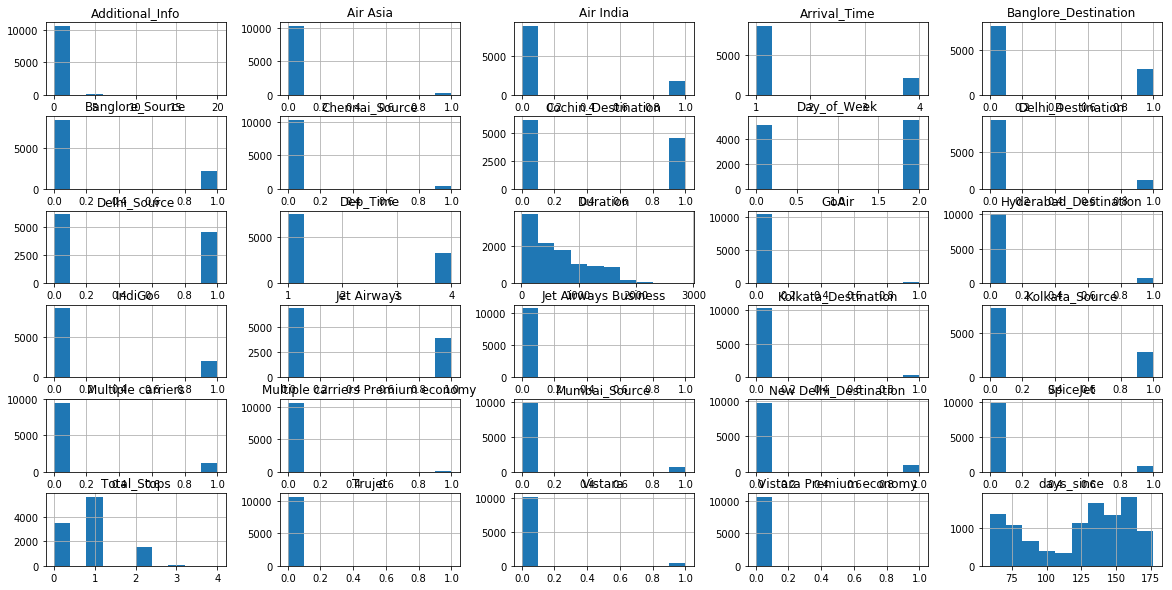

In [20]:
from matplotlib import pyplot as plt
trainData.hist(figsize = (20,10))
plt.show()

       Price
Price    1.0


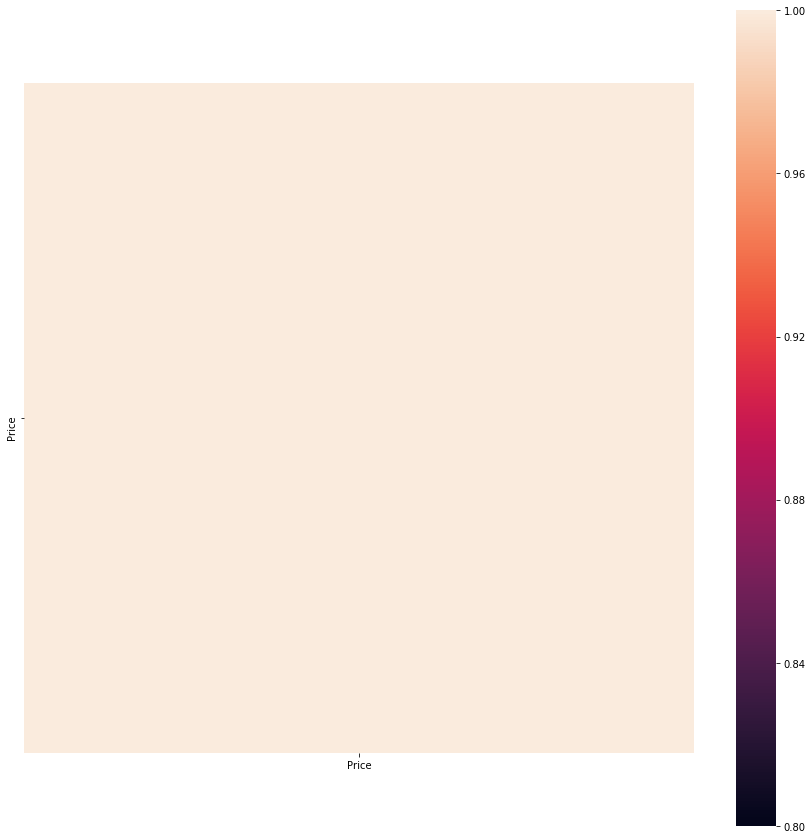

In [50]:
import seaborn as sb
#df = trainData
#df['Price'] = trainLabels

corrMat = dataFrame.corr()
fig = plt.figure(figsize = (15,15))
print(corrMat)
sb.heatmap(corrMat, vmax = .8, square = True)
plt.show()

In [40]:
model = buildModel()
result, predictions = trainModel(model, trainData, trainLabels, 500, 100)

Epoch 1/100
10683/10683 [==============================] - 1s 59us/step - loss: 15127.5939 - acc: 0.0000e+00
Epoch 2/100
10683/10683 [==============================] - 0s 11us/step - loss: 4062.1883 - acc: 2.8082e-04
Epoch 3/100
10683/10683 [==============================] - 0s 13us/step - loss: 2917.4383 - acc: 2.8082e-04
Epoch 4/100
10683/10683 [==============================] - 0s 11us/step - loss: 2797.0032 - acc: 1.8721e-04
Epoch 5/100
10683/10683 [==============================] - 0s 13us/step - loss: 2757.1706 - acc: 0.0000e+00
Epoch 6/100
10683/10683 [==============================] - 0s 11us/step - loss: 2743.3440 - acc: 3.7443e-04
Epoch 7/100
10683/10683 [==============================] - 0s 11us/step - loss: 2730.4697 - acc: 1.8721e-04
Epoch 8/100
10683/10683 [==============================] - 0s 11us/step - loss: 2724.6288 - acc: 3.7443e-04
Epoch 9/100
10683/10683 [==============================] - 0s 12us/step - loss: 2716.6863 - acc: 9.3607e-05
Epoch 10/100
10683/10683 [=

10683/10683 [==============================] - 0s 10us/step - loss: 2291.0841 - acc: 0.0000e+00
Epoch 77/100
10683/10683 [==============================] - 0s 12us/step - loss: 2298.8777 - acc: 2.8082e-04
Epoch 78/100
10683/10683 [==============================] - 0s 11us/step - loss: 2274.2836 - acc: 9.3607e-05
Epoch 79/100
10683/10683 [==============================] - 0s 10us/step - loss: 2290.3516 - acc: 4.6803e-04
Epoch 80/100
10683/10683 [==============================] - 0s 11us/step - loss: 2259.1857 - acc: 9.3607e-05
Epoch 81/100
10683/10683 [==============================] - 0s 10us/step - loss: 2250.4359 - acc: 3.7443e-04
Epoch 82/100
10683/10683 [==============================] - 0s 11us/step - loss: 2237.7483 - acc: 2.8082e-04
Epoch 83/100
10683/10683 [==============================] - 0s 10us/step - loss: 2254.5855 - acc: 2.8082e-04
Epoch 84/100
10683/10683 [==============================] - 0s 10us/step - loss: 2225.7973 - acc: 4.6803e-04
Epoch 85/100
10683/10683 [======

In [41]:
print(result)

[2121.5542071488067, 0.00065524665356173355]


In [42]:
print(predictions)

[[  5231.14111328]
 [  8788.65820312]
 [ 13296.8515625 ]
 ..., 
 [  6943.94873047]
 [  6274.11621094]
 [  8194.8046875 ]]


In [14]:
print(trainLabels)

0         3897
1         7662
2        13882
3         6218
4        13302
5         3873
6        11087
7        22270
8        11087
9         8625
10        8907
11        4174
12        4667
13        9663
14        4804
15       14011
16        5830
17       10262
18       13381
19       12898
20       19495
21        6955
22        3943
23        4823
24        7757
25       13292
26        8238
27        7682
28        4668
29        3687
         ...  
10653    14388
10654     4319
10655     5678
10656     5613
10657     9663
10658     5769
10659     4668
10660     4878
10661     8372
10662    12352
10663    11733
10664     4823
10665     4804
10666    10262
10667    11087
10668    21219
10669     9929
10670    11411
10671     3100
10672    11150
10673    16704
10674    11087
10675     3100
10676     9794
10677     3257
10678     4107
10679     4145
10680     7229
10681    12648
10682    11753
Name: Price, Length: 10683, dtype: int64
